In [1]:
import pbj
import numpy
import numpy as np

### Create .vert and .face

In [2]:
molecule = 'methanol'

import subprocess
msms_command = ["msms", "-if", f"{molecule}/{molecule}.xyzr", "-of", f"{molecule}/{molecule}", "-d", "8", "-p", "1.4", "-no_header"]
subprocess.run(msms_command)

MSMS 2.6.1 started on tulio
Copyright M.F. Sanner (1994)
Compilation flags -O2 -DVERBOSE -DTIMING
INPUT  methanol/methanol.xyzr 3 spheres 0 collision only, radii  0.200 to  1.888
PARAM  Probe_radius  1.400 density  8.000 hdensity  3.000
REDUCED SURFACE ...
    RS component  #faces  #edges #free_edges  #vertices   genus
         0           0        0          1          2      0.5
    Time Reduced Surface real: 0.00 user: 0.00 sys: 0.00
ANALYTICAL SOLVENT EXCLUDED SURFACE...
    Component   0
        Time Surface real: 0.00 user: 0.00 sys: 0.00
    SES comp.  #fac.  #edg. #s_edg. #vert. #s_vert. R_h C_h genus
         0        3      3      0       2        0   0   0    0
ANALYTICAL SURFACE AREA :
    Comp. probe_radius,   reent,    toric,   contact    SES       SAS
      0       1.400       0.000     6.139    46.868    53.007   151.129
TRIANGULATION...
    Component 0
    component#, vertices,  edges,  faces, genus, density
        0            373    1113     742    0     7.037
     

    Couldn't find first face trying -all option


CompletedProcess(args=['msms', '-if', 'methanol/methanol.xyzr', '-of', 'methanol/methanol', '-d', '8', '-p', '1.4', '-no_header'], returncode=0)

### Import .pqr

In [3]:
molecule = 'methanol'
mol_object = pbj.electrostatics.Solute(f"{molecule}/{molecule}.pqr", mesh_density=6, mesh_generator='msms', save_mesh_build_files=True)
simulation = pbj.Simulation()
simulation.add_solute(mol_object)


/home/martinachondo/.local/lib/python3.9/site-packages/pbj/mesh/ExternalSoftware/MSMS/msms -if /home/martinachondo/Simulations/mesh_files/methanol.xyzr -of /home/martinachondo/Simulations/mesh_files/methanol -p 1.4 -d 6 -no_header
MSMS 2.6.1 started on tulio
Copyright M.F. Sanner (1994)
Compilation flags -O2 -DVERBOSE -DTIMING
Atom 4 ignored, radius = 0.010000
INPUT  /home/martinachondo/Simulations/mesh_files/methanol.xyzr 3 spheres 0 collision only, radii  0.200 to  1.888
PARAM  Probe_radius  1.400 density  6.000 hdensity  3.000
REDUCED SURFACE ...
    RS component  #faces  #edges #free_edges  #vertices   genus
         0           0        0          1          2      0.5
    Time Reduced Surface real: 0.00 user: 0.00 sys: 0.00
ANALYTICAL SOLVENT EXCLUDED SURFACE...
    Component   0
        Time Surface real: 0.00 user: 0.00 sys: 0.00
    SES comp.  #fac.  #edg. #s_edg. #vert. #s_vert. R_h C_h genus
         0        3      3      0       2        0   0   0    0
ANALYTICAL SURFACE A

    Couldn't find first face trying -all option


In [4]:
simulation.solutes[0].ep_in = 1
simulation.solutes[0].ep_ex = 80
simulation.solutes[0].kappa = 0.125

### Create evaluation Points

In [5]:
# Plane
verts = simulation.solutes[0].dirichl_space.grid.vertices
xmax = numpy.max(verts[0,:],axis=0)
xmin = numpy.min(verts[0,:],axis=0)
ymax = numpy.max(verts[1,:],axis=0)
ymin = numpy.min(verts[1,:],axis=0)
zmax = numpy.max(verts[2,:],axis=0)
zmin = numpy.min(verts[2,:],axis=0)

x = numpy.linspace(xmin, xmax, num=101)
y = numpy.linspace(ymin, ymax, num=101)
z = (zmax+zmin)/2

X,Y,Z = numpy.meshgrid(x,y,z)
eval_points = numpy.column_stack((X.ravel(),Y.ravel(),Z.ravel()))

In [6]:
# Random 

rI = 1.5
R = 10

num_points1 = 3000
x1 = np.random.uniform(-rI, rI, num_points1)
y1 = np.random.uniform(-rI, rI, num_points1)
z1 = np.random.uniform(-rI, rI, num_points1)

num_points2 = 3000
x2 = np.random.uniform(-R, R, num_points2)
y2 = np.random.uniform(-R, R, num_points2)
z2 = np.random.uniform(-R, R, num_points2)


x = np.concatenate((x1, x2))
y = np.concatenate((y1, y2))
z = np.concatenate((z1, z2))

eval_points = numpy.column_stack((x.ravel(),y.ravel(),z.ravel()))

print(eval_points)

[[-1.31894056  1.01348432 -1.09160654]
 [-0.85575315 -0.82367509  1.1648607 ]
 [-1.17576517 -0.34981178  0.36198982]
 ...
 [ 0.37938466  7.99923691  1.81845196]
 [-2.46566531 -5.05534481 -2.46177143]
 [ 5.43499507  6.74027271 -3.6973795 ]]


### Calculate phi at interface, solute and solvent

In [7]:
phi_solute, points_solute = simulation.calculate_coulomb_potential_solute(eval_points, units='e_eps0_angs')

In [8]:
phir_solute, points_solute = simulation.calculate_reaction_potential_solute(eval_points, units='e_eps0_angs')

66 warnings generated.
/home/martinachondo/miniconda3/envs/pbj/lib/python3.9/site-packages/pyopencl/__init__.py:270: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "
66 warnings generated.
66 warnings generated.
66 warnings generated.
66 warnings generated.
66 warnings generated.
66 warnings generated.
66 warnings generated.
66 warnings generated.
66 warnings generated.
66 warnings generated.
66 warnings generated.
66 warnings generated.
66 warnings generated.
66 warnings generated.
66 warnings generated.


In [9]:
phi_sol_T = phi_solute + phir_solute

In [10]:
phi_solv, points_solvent = simulation.calculate_potential_solvent(eval_points,units='e_eps0_angs')

66 warnings generated.
66 warnings generated.
66 warnings generated.
66 warnings generated.


In [11]:
phi = phi_sol_T + phi_solv

### Calculate phi_ens

In [ ]:
simulation.calculate_potential_ens(mesh_dx=2.)
phi_ens = simulation.solutes[0].results['phi_ens']

### Calculate solvation energy

In [ ]:
simulation.calculate_solvation_energy()
G_solv = simulation.solutes[0].results['solvation_energy']
G_solv

### Export results

In [ ]:
import os 

cwd = os.getcwd()

with open(os.path.join(cwd,molecule,'data_experimental.dat'), 'w') as file:
    for i in range(len(phi_ens)):
        file.write(f'{i+1}   {phi_ens[i]}\n')       

In [ ]:
phi_1 = phi_sol_T[points_solute==0]
X_1 = eval_points[points_solute==0]
phi_2 = phi_solv[points_solvent]
X_2 = eval_points[points_solvent]

with open(os.path.join(cwd,molecule,'data_known.dat'), 'w') as file:
    for i in range(len(phi_1)):
        file.write(f'{1} {X_1[i,0]} {X_1[i,1]} {X_1[i,2]} {phi_1[i]}\n')
    for i in range(len(phi_2)):
        file.write(f'{2} {X_2[i,0]} {X_2[i,1]} {X_2[i,2]} {phi_2[i]}\n')

### Plot results

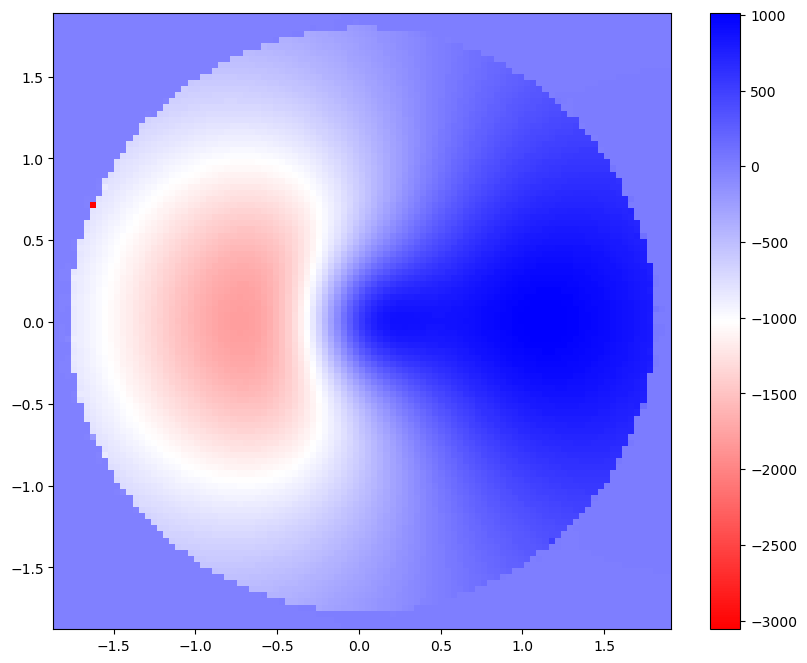

In [16]:
phi_2D = numpy.reshape(phi,(len(x),len(y)))

from matplotlib import pyplot as plt
fig=plt.figure(figsize=(10,8))
plt.imshow(phi_2D, extent=[x[0],x[-1],y[0],y[-1]], cmap='bwr_r')#,vmin=-50,vmax=50)
plt.colorbar()
plt.show()

In [17]:
simulation.solutes[0].results.keys()

dict_keys(['phi', 'd_phi', 'phi_ens', 'phir_charges', 'solvation_energy'])

In [29]:
np.max(simulation.solutes[0].results['phi'].coefficients)

0.0007339597329053323